1. Setting up the Environment and Loading the Dataset
Install PySpark and Pandas (if not installed)
pip install pyspark pandas

In [1]:
# Load the Data

import pandas as pd
from pyspark.sql import SparkSession

# Start a PySpark session
spark = SparkSession.builder.appName("EcommerceAnalysis").getOrCreate()

# Load the dataset into a Pandas DataFrame (can be loaded directly from a CSV)
file_path = "data/OnlineRetail.csv"
df_pandas = pd.read_csv(file_path, encoding='unicode_escape')

# Convert the Pandas DataFrame into a PySpark DataFrame
df_spark = spark.createDataFrame(df_pandas)


2. Data Cleaning
Handle Missing and Invalid Values

In [2]:
from pyspark.sql.functions import col

# Drop rows with missing CustomerID and InvoiceNo
df_clean = df_spark.na.drop(subset=["CustomerID", "InvoiceNo"])

# Filter out negative or zero quantities and invalid UnitPrice values
df_clean = df_clean.filter((col("Quantity") > 0) & (col("UnitPrice") > 0))

# Check cleaned data
df_clean.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|   17850.0|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



3. Data Preprocessing
Compute Total Purchase Value

In [3]:
from pyspark.sql.functions import expr

# Create a new column for the total purchase value per transaction
df_clean = df_clean.withColumn("TotalValue", col("Quantity") * col("UnitPrice"))

# Check for new column
df_clean.select("InvoiceNo", "CustomerID", "TotalValue").show(5)

+---------+----------+------------------+
|InvoiceNo|CustomerID|        TotalValue|
+---------+----------+------------------+
|   536365|   17850.0|15.299999999999999|
|   536365|   17850.0|             20.34|
|   536365|   17850.0|              22.0|
|   536365|   17850.0|             20.34|
|   536365|   17850.0|             20.34|
+---------+----------+------------------+
only showing top 5 rows



In [4]:
# Aggregate Data by Customer
# compute total purchases, frequency of transactions, and recency for each customer
from pyspark.sql.functions import count, sum, avg, max

# Calculate RFM (Recency, Frequency, Monetary) features for each customer
df_rfm = df_clean.groupBy("CustomerID") \
    .agg(
        count("InvoiceNo").alias("Frequency"),       # Frequency of transactions
        sum("TotalValue").alias("Monetary"),         # Total value of purchases (Monetary)
        max("InvoiceDate").alias("LastPurchaseDate") # Most recent purchase date (Recency)
    )

df_rfm.show(5)


+----------+---------+------------------+----------------+
|CustomerID|Frequency|          Monetary|LastPurchaseDate|
+----------+---------+------------------+----------------+
|   12346.0|        1|           77183.6| 1/18/2011 10:01|
|   12347.0|      182|            4310.0|   8/2/2011 8:48|
|   12348.0|       31|           1797.24| 9/25/2011 13:13|
|   12349.0|       73|           1757.55| 11/21/2011 9:51|
|   12350.0|       17|334.40000000000003|  2/2/2011 16:01|
+----------+---------+------------------+----------------+
only showing top 5 rows



4. Customer Segmentation: RFM Analysis
Using Recency, Frequency, and Monetary values to segment customers.

Define RFM Scores
To score customers on a scale for recency, frequency, and monetary.

In [5]:
# Compute Recency (how recent the last purchase was in days)
from pyspark.sql.functions import datediff, current_date

df_rfm = df_rfm.withColumn("Recency", datediff(current_date(), col("LastPurchaseDate")))

# Divide customers into bins based on Recency, Frequency, and Monetary scores
# Example: using quantile-based scoring

# Recency score (lower is better)
df_rfm = df_rfm.withColumn("RecencyScore", expr("CASE WHEN Recency <= 30 THEN 5 WHEN Recency <= 60 THEN 4 WHEN Recency <= 90 THEN 3 WHEN Recency <= 120 THEN 2 ELSE 1 END"))

# Frequency score (higher is better)
df_rfm = df_rfm.withColumn("FrequencyScore", expr("CASE WHEN Frequency >= 50 THEN 5 WHEN Frequency >= 20 THEN 4 WHEN Frequency >= 10 THEN 3 WHEN Frequency >= 5 THEN 2 ELSE 1 END"))

# Monetary score (higher is better)
df_rfm = df_rfm.withColumn("MonetaryScore", expr("CASE WHEN Monetary >= 10000 THEN 5 WHEN Monetary >= 5000 THEN 4 WHEN Monetary >= 2000 THEN 3 WHEN Monetary >= 1000 THEN 2 ELSE 1 END"))

# Calculate total RFM score
df_rfm = df_rfm.withColumn("RFMScore", col("RecencyScore") + col("FrequencyScore") + col("MonetaryScore"))

df_rfm.show(5)


+----------+---------+------------------+----------------+-------+------------+--------------+-------------+--------+
|CustomerID|Frequency|          Monetary|LastPurchaseDate|Recency|RecencyScore|FrequencyScore|MonetaryScore|RFMScore|
+----------+---------+------------------+----------------+-------+------------+--------------+-------------+--------+
|   12346.0|        1|           77183.6| 1/18/2011 10:01|   NULL|           1|             1|            5|       7|
|   12347.0|      182|            4310.0|   8/2/2011 8:48|   NULL|           1|             5|            3|       9|
|   12348.0|       31|           1797.24| 9/25/2011 13:13|   NULL|           1|             4|            2|       7|
|   12349.0|       73|           1757.55| 11/21/2011 9:51|   NULL|           1|             5|            2|       8|
|   12350.0|       17|334.40000000000003|  2/2/2011 16:01|   NULL|           1|             3|            1|       5|
+----------+---------+------------------+---------------

5. Identify High-Value and Infrequent Buyers
High-Value Customers
We can identify high-value customers as those with the highest Monetary scores.

In [6]:
high_value_customers = df_rfm.filter(col("MonetaryScore") >= 4).orderBy(col("MonetaryScore").desc())
high_value_customers.show(10)


+----------+---------+------------------+----------------+-------+------------+--------------+-------------+--------+
|CustomerID|Frequency|          Monetary|LastPurchaseDate|Recency|RecencyScore|FrequencyScore|MonetaryScore|RFMScore|
+----------+---------+------------------+----------------+-------+------------+--------------+-------------+--------+
|   12471.0|      460|          19824.05| 9/22/2011 17:25|   NULL|           1|             5|            5|      11|
|   12744.0|      222|          21279.29| 7/18/2011 11:55|   NULL|           1|             5|            5|      11|
|   12477.0|      300|13219.739999999998|  8/31/2011 9:11|   NULL|           1|             5|            5|      11|
|   12557.0|       33|          11990.96|  7/4/2011 13:19|   NULL|           1|             4|            5|      10|
|   12731.0|      274|          18895.91| 9/30/2011 12:06|   NULL|           1|             5|            5|      11|
|   12621.0|      467|13689.669999999998| 9/19/2011 14:5

Infrequent Buyers
Customers who make infrequent purchases but have significant recency and monetary values can be categorized as infrequent buyers.

In [7]:
infrequent_buyers = df_rfm.filter(col("Frequency") <= 1).orderBy(col("Monetary").desc())
infrequent_buyers.show(10)

+----------+---------+-----------------+----------------+-------+------------+--------------+-------------+--------+
|CustomerID|Frequency|         Monetary|LastPurchaseDate|Recency|RecencyScore|FrequencyScore|MonetaryScore|RFMScore|
+----------+---------+-----------------+----------------+-------+------------+--------------+-------------+--------+
|   12346.0|        1|          77183.6| 1/18/2011 10:01|   NULL|           1|             1|            5|       7|
|   15195.0|        1|           3861.0| 12/7/2011 12:20|   NULL|           1|             1|            3|       5|
|   13135.0|        1|           3096.0| 5/27/2011 10:52|   NULL|           1|             1|            3|       5|
|   17846.0|        1|           2033.1| 9/15/2011 15:20|   NULL|           1|             1|            3|       5|
|   18133.0|        1|931.4999999999999| 5/11/2011 14:14|   NULL|           1|             1|            1|       3|
|   13270.0|        1|            590.0| 12/8/2010 14:53|   NULL

6. Pareto Principle Analysis (80/20 Rule)
Calculate the top 20% customers contributing to 80% of revenue.

Calculate Total Revenue and Rank Customers by Monetary Value

In [8]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank

# Rank customers by their monetary contribution
window_spec = Window.orderBy(col("Monetary").desc())
df_rfm = df_rfm.withColumn("Rank", rank().over(window_spec))

# Calculate total revenue
total_revenue = df_rfm.agg(sum("Monetary")).collect()[0][0]

# Calculate the cumulative revenue for customers
df_rfm = df_rfm.withColumn("CumulativeRevenue", sum("Monetary").over(window_spec))

# Calculate percentage of total revenue
df_rfm = df_rfm.withColumn("RevenuePercentage", (col("CumulativeRevenue") / total_revenue) * 100)

# Filter customers contributing to 80% of revenue
top_20_customers = df_rfm.filter(col("RevenuePercentage") <= 80)
top_20_customers.show(10)


+----------+---------+------------------+----------------+-------+------------+--------------+-------------+--------+----+------------------+------------------+
|CustomerID|Frequency|          Monetary|LastPurchaseDate|Recency|RecencyScore|FrequencyScore|MonetaryScore|RFMScore|Rank| CumulativeRevenue| RevenuePercentage|
+----------+---------+------------------+----------------+-------+------------+--------------+-------------+--------+----+------------------+------------------+
|   14646.0|     2076| 280206.0199999999|  9/8/2011 11:28|   NULL|           1|             5|            5|      11|   1| 280206.0199999999|3.1443518579620333|
|   18102.0|      431|259657.29999999996| 9/28/2011 16:17|   NULL|           1|             5|            5|      11|   2| 539863.3199999998| 6.058114787425167|
|   17450.0|      337|194550.78999999998|  9/5/2011 13:52|   NULL|           1|             5|            5|      11|   3| 734414.1099999999| 8.241280366824503|
|   16446.0|        3|          16

To visualize the top 20% of customers contributing to 80% of the revenue, we can create a Pareto Chart or a Cumulative Revenue Distribution chart. The most effective approach is to visualize the cumulative revenue contribution by customer rank to show the 80/20 rule.
Step-by-Step Visualization:
Extract the Data from PySpark:
First, we need to collect the data related to customer ranks and cumulative revenue from PySpark and convert it into a Pandas DataFrame for easy plotting.

Create the Pareto Chart:
We will plot the cumulative revenue percentage on the y-axis and customer rank (percentile) on the x-axis. A horizontal line at 80% will show the threshold where 20% of customers contribute to 80% of the revenue.


In [9]:
# Step 1: Collect Data from PySpark to Pandas
# Collect the data with customer rank and revenue percentage
df_pandas_rfm = df_rfm.select("CustomerID", "Monetary", "Rank", "CumulativeRevenue", "RevenuePercentage").toPandas()

# Sort by Rank for visualization purposes
df_pandas_rfm = df_pandas_rfm.sort_values(by="Rank")


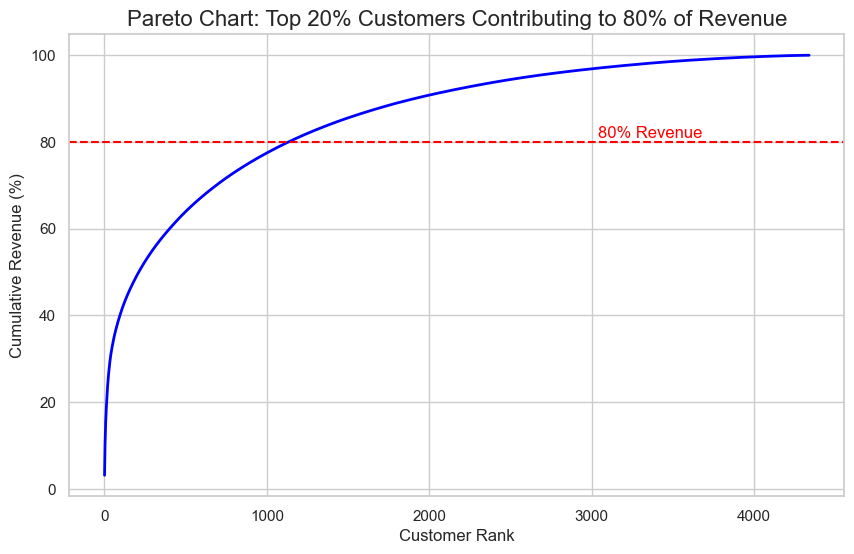

In [10]:
# Step 2: Pareto Chart (Cumulative Revenue Distribution)
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot cumulative revenue as a function of customer rank
plt.figure(figsize=(10,6))

# Line plot for cumulative revenue percentage
plt.plot(df_pandas_rfm['Rank'], df_pandas_rfm['RevenuePercentage'], color='blue', lw=2)

# Horizontal line at 80% (Pareto threshold)
plt.axhline(80, color='red', linestyle='--')

# Labeling
plt.title("Pareto Chart: Top 20% Customers Contributing to 80% of Revenue", fontsize=16)
plt.xlabel("Customer Rank", fontsize=12)
plt.ylabel("Cumulative Revenue (%)", fontsize=12)

# Annotate the 80% line
plt.text(df_pandas_rfm['Rank'].max()*0.7, 81, '80% Revenue', color='red', fontsize=12)

# Show plot
plt.show()

Interpretation of the Plot:
X-axis: The rank of customers (sorted by their revenue contribution). Each point represents a customer.
Y-axis: The cumulative percentage of total revenue.
Red dashed line: This shows the 80% threshold, illustrating the Pareto principle. We can see at which point the top 20% of customers are contributing 80% of the total revenue.

Example Output:
The graph will show a sharp increase in revenue contribution with the first few customers (the high-value customers) and flatten as it progresses towards less contributing customers.